In [157]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rc('axes', titlesize=12)
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### 0- Loading the Data

In [158]:
transactions1 = pd.read_csv("transactions_1.csv", index_col='Unnamed: 0')
transactions2 = pd.read_csv("transactions_2.csv", index_col='Unnamed: 0')
transactions = pd.concat([transactions1, transactions2])

In [159]:
transactions

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z


#### 0-1 Extracting year and month from the date column

In [160]:
transactions['year'] = pd.DatetimeIndex(transactions['date']).year
transactions['month'] = pd.DatetimeIndex(transactions['date']).month
transactions

,customer_id,product_id,date,year,month
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2
...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3


### 2- Basic Questions
### 2-1 Create an ordered (descending) plot for the total number of transactions per customer from the most to the least active customer.

In [161]:
transaction_per_customer = transactions.groupby('customer_id').size()
sorted_trans_per_customer = transaction_per_customer.sort_values(ascending=False)
sorted_trans_per_customer

customer_id
6689489    34963
5381109    33355
1756454    18927
4435859    13450
8350659    10490
           ...  
8964627        1
7695751        1
4877229        1
7742978        1
1646090        1
Length: 2002, dtype: int64

Text(0.5, 1.0, 'sorted number of transactions per customer')

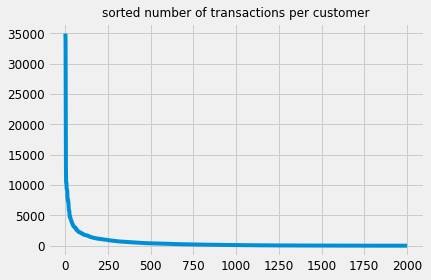

In [162]:
x = sorted_trans_per_customer.reset_index(drop=True)
plt.plot(x)
plt.title('sorted number of transactions per customer')

#### 1-2 Given any product ID, create a plot to show its transaction frequency per month for the year 2018.

In [163]:
def plot_trans_perMonth(productID, year):
    year_filtered_df = transactions[transactions['year'] == year]
    monthly_bill = year_filtered_df.groupby(['product_id', 'month']).size()
    plt.plot(monthly_bill[productID])
    plt.xlabel('month')
    plt.ylabel('# of transactions') 
    plt.title('monthly trancations of '+ productID + ' in ' + str(year))

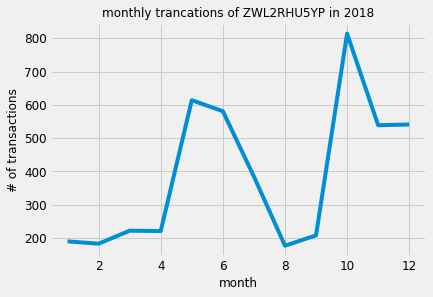

In [164]:
plot_trans_perMonth('ZWL2RHU5YP', 2018)

### 3- At any time, what are the top 5 products that drove the highest sales over the last six months?

In [165]:
def get_last_n_month_highest_sale(n, current_year, current_month):
    tmp_transactions = transactions.copy()
    
    min_year = tmp_transactions['year'].min()
    # create a column of 'number of passed months until now to ease the calculations of past n month transaction history'
    tmp_transactions['acc_month'] = (tmp_transactions['year'] - min_year)*12 + tmp_transactions['month']
    current_acc_month = (current_year - min_year)*12 + current_month
    min_acc_month = (current_year - min_year)*12 + current_month - n + 1
    
    filtered = tmp_transactions[(tmp_transactions['acc_month'] >= min_acc_month)&(tmp_transactions['acc_month']<= current_acc_month)]
    return filtered.groupby('product_id').size().sort_values(ascending=False).head(5)

In [166]:
get_last_n_month_highest_sale(6, 2019, 8)

product_id
5RPSDK28JR    21745
XZ6UVEYK40    10423
VD51ZQPY9D    10204
XD4I34ED7F     9585
G5HEPH9A2T     9267
dtype: int64

### 4- Build a model to predict the total number of expected transactions over the next month for any customer. Split your data appropriately and give enough validation for the performance of your model by simulating the predicted results and comparing with the true values or however you see fit. Keep in mind that sometimes a carefully crafted plot is worth a thousand words.

#### Obviously, this is a time series prediction ML problem (which is new to me), and we are dealing with the concept of time, so I search around the internet and found  these links ([1](https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a), [2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), and [3](https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python)) very helpful and used them to solve this problem.

#### 4-1. Create a proper dataframe which shows us the monthly transactions of each product

In [167]:
def create_monthly_sale_df():
    monthly_trans_df = transactions.copy()
    min_year = monthly_trans_df['year'].min()
    monthly_trans_df['acc_month'] = (monthly_trans_df['year'] - min_year)*12 + monthly_trans_df['month']
    max_month = monthly_trans_df['acc_month'].max()
    monthly_trans_df = monthly_trans_df.drop(columns=['date', 'year', 'month'])
    monthly_trans_df = monthly_trans_df.groupby(['product_id', 'acc_month']).size().to_frame(name = 'count')
    
    monthly_trans_df = monthly_trans_df.pivot_table('count', 'product_id', 'acc_month').fillna(0)
    monthly_trans_df = monthly_trans_df.reset_index().melt(id_vars='product_id', var_name='month', value_name='sales')
    return monthly_trans_df
    

In [168]:
monthly_trans = create_monthly_sale_df()
monthly_trans

,product_id,month,sales
0,0A4G5LZWCP,1,844.0
1,0AB7PTAD3X,1,18.0
2,0HLIWH0CA1,1,691.0
3,0UZVWTQ50H,1,0.0
4,0W3289OYXV,1,38.0
...,...,...,...
1945,YRRT480XIZ,39,12.0
1946,Z4N23EOA13,39,235.0
1947,Z6OHD7VB3J,39,0.0
1948,ZH8YQX1ZL2,39,0.0


#### 4-2 map product_id to an integer and keep the mapping in a dictionary for recovering

In [169]:
monthly_trans['id'] = monthly_trans.index%50 
monthly_trans['id'] = monthly_trans['id'] + 1
monthly_trans['month'] = monthly_trans['month'] - 1
product_id_mapping_dict = monthly_trans[['product_id', 'id']].to_dict('records')
monthly_trans = monthly_trans[['id', 'month', 'sales']]
monthly_trans = monthly_trans.astype('int')
monthly_trans

,id,month,sales
0,1,0,844
1,2,0,18
2,3,0,691
3,4,0,0
4,5,0,38
...,...,...,...
1945,46,38,12
1946,47,38,235
1947,48,38,0
1948,49,38,0


We can see a random product's monthy transactions over 39 months

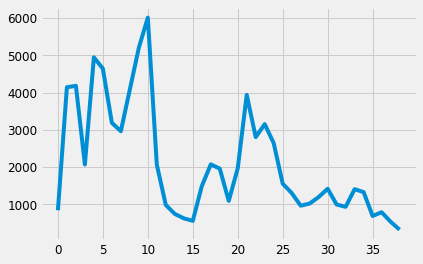

In [170]:
x = monthly_trans[monthly_trans['id'] == 1]['month']
y = monthly_trans[monthly_trans['id'] == 1]['sales']
plt.plot(x, y)

#### Another interesting plot is shown below. We can see that the density of small number of transactions is considerably higher than transactions with high volume. The skewness here can be used to think about using log transformers that amplify values in the lower range of magnitudes and compensate for values in the higher magnitudes. ([Reference](https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a)). The TimeSeriesRegressorLog class in the following will take advantage of this property to provide a better model for our data.

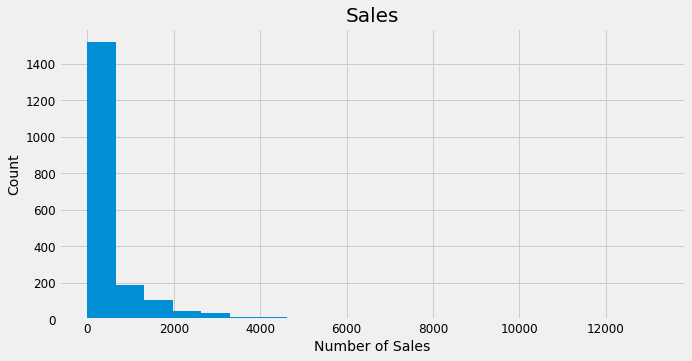

In [171]:
monthly_trans['sales'].hist(bins=20, figsize=(10,5))
plt.xlabel('Number of Sales',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Sales',fontsize=20)
plt.show()

### 4-3 Now, lets try to solve the problem

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

#### 4-3-1 In order to turn a time series forcasting problem to a supervised learning one, one way is to add lags of time as inputs of the ML model (number of these lags can be considered as a hyperparameter of our problem). Here, ToSupervised and ToSupervisedDiff classes prepares and shapes the data in the mentioend format. The conversion to the new data format will be conducted by a simple pipeline.

In [173]:
class ToSupervised(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, num_lags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.num_lags = num_lags
        self.dropna = dropna
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        new_X = self.X.copy()
        for i in range(1, self.num_lags+1):
            new_X[str(i)+'_Month_Ago'+"_"+self.col] = new_X.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            new_X = new_X.dropna()
            new_X = new_X.reset_index(drop=True)
        
        return new_X

In [174]:
class ToSupervisedDiff(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, num_lags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.num_lags = num_lags
        self.dropna = dropna
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        new_X = self.X.copy()
        for i in range(1, self.num_lags+1):
            new_X[str(i)+'_Month_Ago_Diff_'+"_"+self.col] = new_X.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            new_X = new_X.dropna()
            new_X = new_X.reset_index(drop=True)
        
        return new_X

### 1-2 Time-Series K-Fold
##### For the cross validation, here we choose forward chaining approach to evaluate our model

In [175]:
from itertools import chain

class Kfold_time(object):
    
    def __init__(self, **options):
        self.target = options.pop('target', None)
        self.month_col = options.pop('month_col', None)
        self.start_month = options.pop('start_month', None)
        self.end_month = options.pop('end_month', None)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.month_col==None )| (self.start_month==None ) | (self.end_month==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split(self, X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")
        
        for i in range(self.start_month, self.end_month):
            train = X[X[self.month_col] < i]
            val = X[X[self.month_col] == i]
            
            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values
            
            yield X_train, X_test, y_train, y_test
        
    def split(self, X):
        cv_t = self._train_test_split(X)
        return chain(cv_t)

### 1-3 Metric: RMSE

In [176]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#### 1-4 Baseline Estimator
##### The first idea which comes to mind is to assume that the number of sales for every product at the current week will be the same for the next week. 

In [177]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        pred = X[self.predCol].values
        return pred

    def score(self, X, y, scoring):
        
        prediction = self.predict(X)
        error = scoring(y, prediction)
        return error
    

#### 1-5 Time-Series Regression

In [178]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, model, cv, scoring, verbosity=True):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.verbosity = verbosity
        
    def fit(self, X, y=None):
        # just returns the class object (the model will do the fitting itself)
        return self
    
    def predict(self, X=None):
        
        pred = {}
        for idx, fold in enumerate(self.cv.split(X)):
            
            X_train, X_test, y_train, y_test = fold
            self.model.fit(X_train, y_train)
            pred[str(idx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
        return prediction
    
    def score(self, X, y=None):
        
        errors = []
        for idx, fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)
            
            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(idx,error))
        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return error

        

In [179]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.verbosity = verbosity
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for idx, fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(idx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):

        errors = []
        for idx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(idx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

#### 1-6 Data Preparation

In [180]:
steps = [('1_step',ToSupervised('sales','id',1)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(monthly_trans)

In [181]:
super_1

,id,month,sales,1_Month_Ago_sales,1_Month_Ago_Diff__1_Month_Ago_sales
0,1,2,4185,4147.0,3303.0
1,2,2,114,131.0,113.0
2,3,2,1940,1726.0,1035.0
3,4,2,0,0.0,0.0
4,5,2,136,175.0,137.0
...,...,...,...,...,...
1845,46,38,12,19.0,0.0
1846,47,38,235,173.0,-21.0
1847,48,38,0,0.0,0.0
1848,49,38,0,18.0,5.0


#### monthly for months 33 to 38 are considered to measure the performance of the following trained models.

In [183]:
# base model
kf = Kfold_time(target='sales',month_col = 'month', start_month=33,end_month=39)

base_model = BaseEstimator('1_Month_Ago_sales')
errors = []
for indx,fold in enumerate(kf.split(super_1)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmse)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

Fold: 0, Error: 272.930
Fold: 1, Error: 264.548
Fold: 2, Error: 288.238
Fold: 3, Error: 135.771
Fold: 4, Error: 101.783
Fold: 5, Error: 228.085
Total Error 215.226


#### Here, we use Random Forest model which reduces the variance of the prediction in a decision tree model but has a weeker performance than ensemble methods. (Because ensemble methods tend to reduce bias error of the decision tree model)

##### First, we just insert one_month lag column and train the model

In [184]:
# 1-step model
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
steps_1 = [('1_step',ToSupervised('sales','id',1)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1,dropna=True)),
         ('predict_1',TimeSeriesRegressor(model=model,cv=kf,scoring=rmse))]
super_1_p = Pipeline(steps_1).fit(monthly_trans)
Model_1_Error = super_1_p.score(monthly_trans)

Fold: 0, Error: 333.0303
Fold: 1, Error: 406.4909
Fold: 2, Error: 392.9545
Fold: 3, Error: 169.6562
Fold: 4, Error: 104.7341
Fold: 5, Error: 219.7148
Total Error 271.0968


##### It seems it didn't work well:(. Let's increase the number of lags to 3 and see what happens.

In [185]:
steps_3 = [('1_step',ToSupervised('sales','id',3)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1,dropna=True)),
         ('predict_3',TimeSeriesRegressor(model=model,cv=kf,scoring=rmse))]
super_3_p = Pipeline(steps_3).fit(monthly_trans)
Model_3_Error = super_3_p.score(monthly_trans)

Fold: 0, Error: 250.8223
Fold: 1, Error: 231.5314
Fold: 2, Error: 261.3893
Fold: 3, Error: 135.7301
Fold: 4, Error: 121.7293
Fold: 5, Error: 221.0334
Total Error 203.7060


#### A little bit better than the base model! not bad:). How about considering last 6 months columns?

In [186]:
steps_6 = [('1_step',ToSupervised('sales','id',6)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1)),
         ('4_step_diff',ToSupervisedDiff('4_Month_Ago_sales','id',1)),
         ('5_step_diff',ToSupervisedDiff('5_Month_Ago_sales','id',1)),
         ('6_step_diff',ToSupervisedDiff('6_Month_Ago_sales','id',1,dropna=True)),
         ('predict_6',TimeSeriesRegressor(model=model,cv=kf,scoring=rmse))]
super_6_p = Pipeline(steps_6).fit(monthly_trans)
Model_6_Error = super_6_p.score(monthly_trans)

Fold: 0, Error: 176.0591
Fold: 1, Error: 214.0677
Fold: 2, Error: 267.0610
Fold: 3, Error: 131.6955
Fold: 4, Error: 129.3263
Fold: 5, Error: 218.2809
Total Error 189.4151


#### As we can see here and for the future work, the number of lags can be treated as a hyperparameter which can be tuned.

#### Considering the skewness in the data, we can use the log transformer and train the model again.

In [187]:
steps_3_log = [('1_step',ToSupervised('sales','id',3)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1,dropna=True)),
         ('predict_3',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmse))]
super_3_p_log = Pipeline(steps_3_log).fit(monthly_trans)
Model_3_Log_Error = super_3_p_log.score(monthly_trans)

Fold: 0, Error: 299.2635
Fold: 1, Error: 171.4090
Fold: 2, Error: 198.7420
Fold: 3, Error: 133.8859
Fold: 4, Error: 92.9315
Fold: 5, Error: 170.8243
Total Error 177.8427


#### Not bad! we can use it with 6 lags as well.

In [188]:
steps_6_log = [('1_step',ToSupervised('sales','id',6)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1)),
         ('4_step_diff',ToSupervisedDiff('4_Month_Ago_sales','id',1)),
         ('5_step_diff',ToSupervisedDiff('5_Month_Ago_sales','id',1)),
         ('6_step_diff',ToSupervisedDiff('6_Month_Ago_sales','id',1,dropna=True)),
         ('predict_6',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmse))]
super_6_p_log = Pipeline(steps_6_log).fit(monthly_trans)
Model_6_Log_Error = super_6_p_log.score(monthly_trans)
last_6_month_predict = super_6_p_log.predict(monthly_trans)

Fold: 0, Error: 252.5886
Fold: 1, Error: 150.7263
Fold: 2, Error: 221.8697
Fold: 3, Error: 138.3864
Fold: 4, Error: 97.7027
Fold: 5, Error: 177.5303
Total Error 173.1340


#### Again, we can see a little improvement. For the future work, ensemble learning methods and also deep learning approaches can be applied to enhance the outcome. Even without new approaches, there are hyperparameters like number of the lags, random forest parameters and ... which can be tuned to get better results.

### Predicted vs. Real values for last 6 months

In [191]:
last_6_month_predict.head()

,0_fold,1_fold,2_fold,3_fold,4_fold,5_fold
0,1035.685,1487.549,1309.935,809.836,860.272,775.935
1,137.892,126.076,62.010,62.693,64.882,58.454
2,661.803,757.245,551.797,458.352,422.486,308.949
3,0.000,0.000,0.000,0.317,0.031,0.004
4,2.984,0.346,0.290,0.325,0.031,0.004


In [201]:
pred = last_6_month_predict.sum().values
actual = []
final_month = 38
for i in range(5, -1, -1):
    actual.append(monthly_trans[monthly_trans['month'] == (final_month-i)]['sales'].sum())

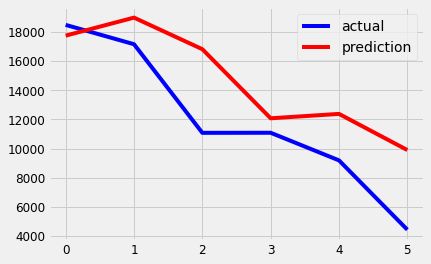

In [208]:
plt.plot(actual, color='b', label='actual')
plt.plot(pred, color='r', label='prediction')
plt.legend(loc="upper right")
plt.show()

#### Saving the final model

In [209]:
import pickle
Pkl_Filename = "6_lag_month_logRegression.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(super_6_p_log, file)

### 5- What other interesting questions can be asked about this? For example, do you see a seasonality effect?

In [210]:
transactions['season'] = (transactions['month']-1)//3 + 1
transactions

,customer_id,product_id,date,year,month,season
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2,1
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2,1
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2,1
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2,1
...,...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5,2
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10,4
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3,1


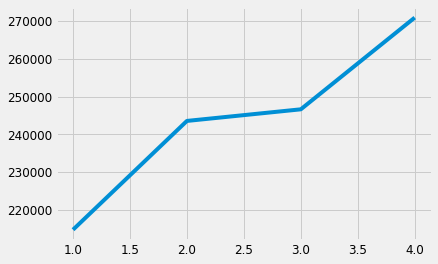

In [211]:
# seasonal transactions
plt.plot(transactions.groupby(['season']).size())

#### As we can see here, number of sales in the last two seasons of the year are relatively more than first two seasons.

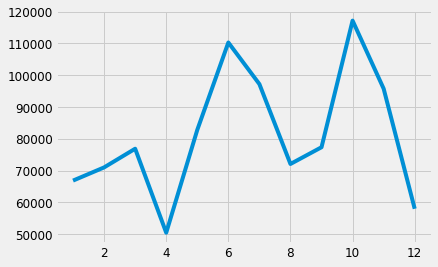

In [212]:
# monthly transactions
plt.plot(transactions.groupby(['month']).size())

<function matplotlib.pyplot.show(close=None, block=None)>

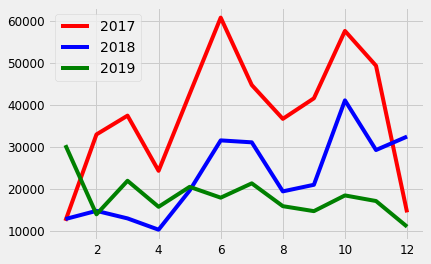

In [214]:
# monthly for each year
plt.plot(transactions[transactions['year'] == 2017].groupby(['month']).size(), color='r', label='2017')
plt.plot(transactions[transactions['year'] == 2018].groupby(['month']).size(), color='b', label='2018')
plt.plot(transactions[transactions['year'] == 2019].groupby(['month']).size(), color='g', label='2019')
plt.legend()
plt.show

#### Furthermore, if we want to be more precise and examine it monthly, month no. 6 (June) and 10 (October) are the pics in the 2017 and 2018 but for the 2019, there is no considerable pic in the sales number.